In [1]:
import pandas as pd
import numpy as np, pandas as pd
from scipy import stats
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import geopandas as gpd
from geopandas import GeoDataFrame
import warnings
import hashlib
import h3
from h3 import h3
import json
from shapely.ops import unary_union
import matplotlib.pyplot as plt

### Introduction 
In this notebook, we will work with a dataset of Chicago's community areas. Our goal is to create hexagons based on this dataset. We will develop two functions: `hexagonize_geodataframe`, which generates hexagons of a specified size, and `assign_hexagons_to_areas`, which assigns the generated hexagons back to the community areas through a spatial join.

In [2]:
# Read the GeoJSON file of the Chicago Community Areas
geojson_file = "../Datasets/Boundaries - Community Areas.geojson"
gdf = gpd.read_file(geojson_file)
gdf.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


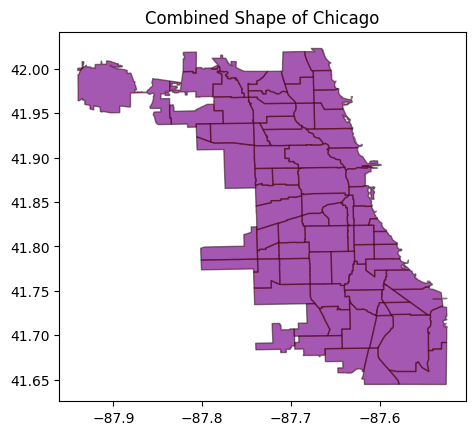

In [3]:
# Combine all the community areas into one shape (union of all geometries)
chicago_shape = unary_union(gdf['geometry'])

# Plot to visualize the combined shape
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k')
gpd.GeoSeries([chicago_shape]).plot(ax=ax, color='red', alpha=0.3)
plt.title('Combined Shape of Chicago')
plt.show()


In [4]:
chicago_shape.geom_type

'MultiPolygon'

In [5]:
# Define the function to convert geometries to hexagons
def hexagonize_geodataframe(geometry, hex_size):
    """
    Convert a geometry to hexagons.
    
    Parameters:
    geometry (shapely.geometry): Input geometry to convert.
    hex_size (int): The hexagon size parameter for h3.
    
    Returns:
    GeoDataFrame: A GeoDataFrame with hexagonal cells.
    """
    hexagons = set()
    if isinstance(geometry, (Polygon, MultiPolygon)):
        # If it's a MultiPolygon, iterate over each Polygon
        if isinstance(geometry, MultiPolygon):
            geometries = geometry.geoms
        else:
            geometries = [geometry]
        
        for geom in geometries:
            if geom.is_empty:
                continue
            # Get the hexagons for the current geometry
            hexes = h3.polyfill(geom.__geo_interface__, hex_size, geo_json_conformant=True)
            hexagons.update(hexes)
    
    # Convert hexagons to GeoDataFrame
    hex_geometries = [h3.h3_to_geo_boundary(h, geo_json=True) for h in hexagons]
    hex_polygons = [Polygon(hex_geom) for hex_geom in hex_geometries]
    hex_gdf = gpd.GeoDataFrame(geometry=hex_polygons)
    
    return hex_gdf

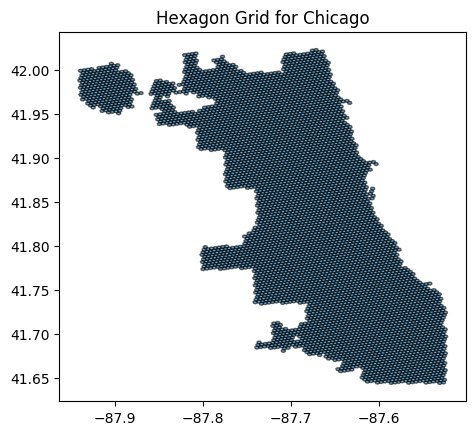

                                            geometry
0  POLYGON ((-87.69924 41.82903, -87.70105 41.827...
1  POLYGON ((-87.64967 41.91839, -87.65149 41.917...
2  POLYGON ((-87.69866 41.75538, -87.70047 41.754...
3  POLYGON ((-87.72000 41.86420, -87.72182 41.863...
4  POLYGON ((-87.80030 41.91785, -87.80211 41.916...


In [6]:
# Example usage for the entire city
hex_size = 9  # Example hexagon size
chicago_hex_gdf = hexagonize_geodataframe(chicago_shape, hex_size)

# Plot to visualize the hexagons
fig, ax = plt.subplots()
chicago_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.6)
plt.title('Hexagon Grid for Chicago')
plt.show()

# Display the first few rows of the hexagon GeoDataFrame
print(chicago_hex_gdf.head())

In [7]:
# Function to assign hexagons to community areas
def assign_hexagons_to_areas(hex_gdf, areas_gdf):
    """
    Assign hexagons to community areas.
    
    Parameters:
    hex_gdf (GeoDataFrame): GeoDataFrame containing hexagons.
    areas_gdf (GeoDataFrame): GeoDataFrame containing community areas.
    
    Returns:
    GeoDataFrame: A GeoDataFrame with hexagons and their corresponding community area.
    """
    # Perform a spatial join to assign hexagons to community areas
    joined_gdf = gpd.sjoin(hex_gdf, areas_gdf, how='left')
    return joined_gdf

In [8]:
# Assign hexagons to community areas
assigned_hex_gdf = assign_hexagons_to_areas(chicago_hex_gdf, gdf)

/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_15987/440296932.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  joined_gdf = gpd.sjoin(hex_gdf, areas_gdf, how='left')


                                            geometry  index_right  \
0  POLYGON ((-87.69924 41.82903, -87.70105 41.827...           56   
1  POLYGON ((-87.64967 41.91839, -87.65149 41.917...           67   
2  POLYGON ((-87.69866 41.75538, -87.70047 41.754...           68   
3  POLYGON ((-87.72000 41.86420, -87.72182 41.863...           29   
4  POLYGON ((-87.80030 41.91785, -87.80211 41.916...           25   

        community area     shape_area perimeter area_num_1 area_numbe  \
0   BRIGHTON PARK    0  75892790.3114         0         58         58   
1    LINCOLN PARK    0  88316400.4728         0          7          7   
2         ASHBURN    0  135460337.208         0         70         70   
3  NORTH LAWNDALE    0  89487422.0242         0         29         29   
4          AUSTIN    0  199254203.427         0         25         25   

  comarea_id comarea      shape_len  
0          0       0  36537.1343061  
1          0       0  49478.4277714  
2          0       0  54818.1546

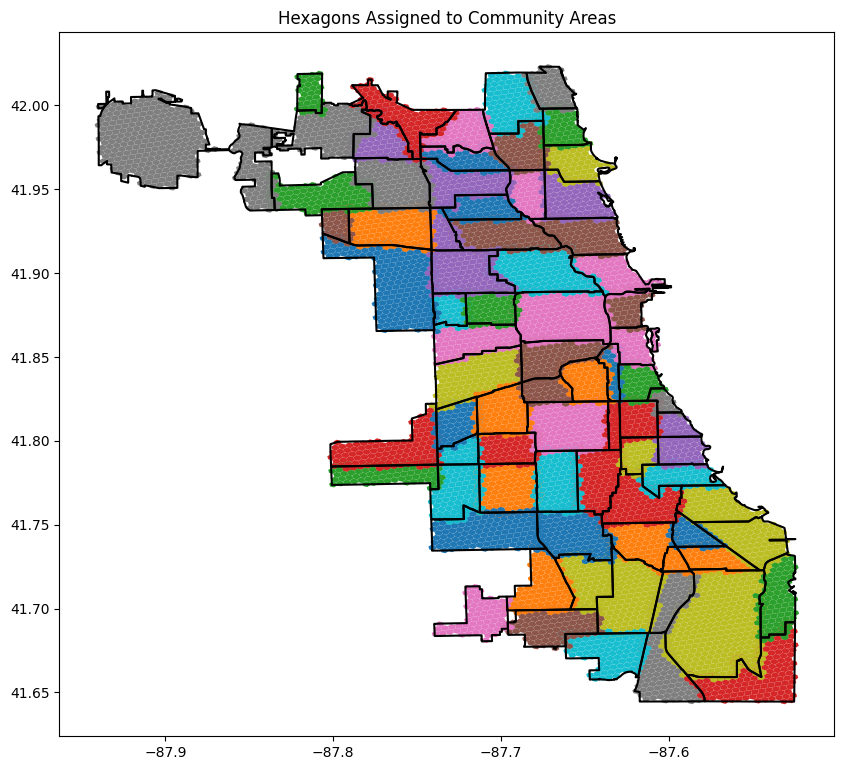

In [9]:
# Display the first few rows of the assigned hexagons GeoDataFrame
print(assigned_hex_gdf.head())

# Plot to visualize the hexagons with community areas
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, color='black')
assigned_hex_gdf.plot(ax=ax, column='community')
plt.title('Hexagons Assigned to Community Areas')
plt.show()

### Showcase of the top 5 farest rides

In [10]:
data = pd.read_pickle("../Datasets/taxi_trips_with_weather_cleaned.pkl")
data.head()

,trip_id,taxi_id,timestamp_start,timestamp_end,duration,distance,fare,tips,tolls,extras,...,dropoff_long,dropoff_location,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precipitation_rate,precipitation_accumulation
0,0cd46aa628ea5f871630113eb8ba92e4,09a6eaba341c43fc653756deff43a50f,2020-01-01,2020-01-01 00:15:00,180.0,0.64,4.50,0.00,0.0,1.0,...,-87.626211,POINT (-87.6262105324 41.8991556134),-2.83,-5.33,83.0,0.48,0.64,1.0088,0.0,0.0
1,4fbe84436a116f11c51ef3306e7adf0c,0f66b306ebea0f05dd124bf958729b64,2020-01-01,2020-01-01 00:30:00,1723.0,1.13,12.00,0.00,0.0,0.0,...,-87.626215,POINT (-87.6262149064 41.8925077809),-2.83,-5.33,83.0,0.48,0.64,1.0088,0.0,0.0
2,08a197de2703972bad8877628b18bb30,5a3410255ea0041b967e74090838b14d,2020-01-01,2020-01-01 00:00:00,420.0,0.97,6.00,0.00,0.0,1.0,...,-87.618868,POINT (-87.6188683546 41.8909220259),-2.83,-5.33,83.0,0.48,0.64,1.0088,0.0,0.0
3,94f8c8a4624a061988e0f32e12be04c5,3049f212da83687eb7ea5cb9d3046d89,2020-01-01,2020-01-01 00:30:00,1320.0,8.21,16.75,3.85,0.0,2.0,...,-87.676356,POINT (-87.6763559892 41.9012069941),-2.83,-5.33,83.0,0.48,0.64,1.0088,0.0,0.0
4,dd25d5229b1ce93ea03b7c9357e6f4f9,d9d9d16f34141de38105a060abd8a90c,2020-01-01,2020-01-01 00:15:00,504.0,1.19,6.25,0.00,0.0,1.0,...,-87.626215,POINT (-87.6262149064 41.8925077809),-2.83,-5.33,83.0,0.48,0.64,1.0088,0.0,0.0


In [11]:
TOP_5_Rides = data.nlargest(5, 'distance')

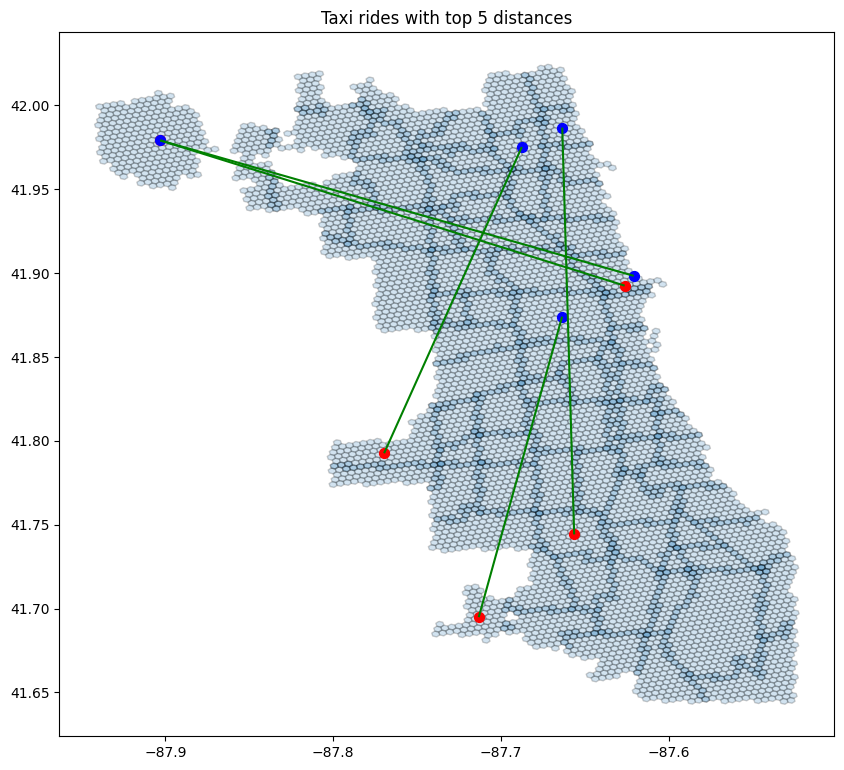

In [12]:
# Get coordinates of the start points and end points
start_points = TOP_5_Rides.apply(lambda row: Point(row['pickup_long'], row['pickup_lat']), axis=1)
end_points = TOP_5_Rides.apply(lambda row: Point(row['dropoff_long'], row['dropoff_lat']), axis=1)

# GDF
start_points_gdf = gpd.GeoDataFrame(geometry=start_points)
end_points_gdf = gpd.GeoDataFrame(geometry=end_points)

# Connect the start and end points with lines
lines = [LineString([start, end]) for start, end in zip(start_points, end_points)]
lines_gdf = gpd.GeoDataFrame(geometry=lines)

# Creat a plot
fig, ax = plt.subplots(figsize=(10, 10))
assigned_hex_gdf.plot(ax=ax, edgecolor='k', alpha=0.2)
start_points_gdf.plot(ax=ax, color='red', markersize=50)
end_points_gdf.plot(ax=ax, color='blue', markersize=50)
lines_gdf.plot(ax=ax, color='green')
plt.title('Taxi rides with top 5 distances')
plt.show()

### Joining POIs to the hexagon map

In [13]:
# Read the GeoJSON file of the Chicago POIs
geojson_file = "../Datasets/POI.geojson"
POI_BIG = gpd.read_file(geojson_file)
POI_BIG.head()

,id,@id,access,addr:city,addr:country,addr:floor,addr:full,addr:housename,addr:housenumber,addr:place,...,website,website:menu,website:store,wheelchair,wheelchair:description,wifi,wikidata,wikipedia,yelp,geometry
0,node/271275603,node/271275603,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (-87.62551 41.88481)
1,node/306741002,node/306741002,None,Chicago,None,None,None,None,600,None,...,None,None,None,yes,None,None,None,None,None,POINT (-87.60966 41.89141)
2,node/311438932,node/311438932,None,None,None,None,None,None,None,None,...,https://neofuturists.org/,None,None,None,None,None,Q16254317,en:Neo-Futurists,None,POINT (-87.66933 41.97579)
3,node/313107974,node/313107974,None,Chicago,None,None,None,None,700,None,...,https://www.imax.com/oo/navy-pier-imax/,None,None,None,None,None,Q37760649,None,None,POINT (-87.60924 41.89190)
4,node/318274065,node/318274065,None,Chicago,None,None,None,None,61,None,...,https://www.pizanoschicago.com/locations/chica...,None,None,None,None,None,None,None,None,POINT (-87.62567 41.88198)


In [14]:
POI = POI_BIG[['id', 'name', 'amenity', 'geometry']]
POI.head()

,id,name,amenity,geometry
0,node/271275603,Storefront Theater,theatre,POINT (-87.62551 41.88481)
1,node/306741002,Bubba Gump Shrimp Company,restaurant,POINT (-87.60966 41.89141)
2,node/311438932,Neofuturists,theatre,POINT (-87.66933 41.97579)
3,node/313107974,Navy Pier IMAX Theatre,cinema,POINT (-87.60924 41.89190)
4,node/318274065,Pizano's Pizza & Pasta,restaurant,POINT (-87.62567 41.88198)


In [15]:
POI.info()
POI.geometry

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4111 entries, 0 to 4110
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        4111 non-null   object  
 1   name      4095 non-null   object  
 2   amenity   3862 non-null   object  
 3   geometry  4111 non-null   geometry
dtypes: geometry(1), object(3)
memory usage: 128.6+ KB


0       POINT (-87.62551 41.88481)
1       POINT (-87.60966 41.89141)
2       POINT (-87.66933 41.97579)
3       POINT (-87.60924 41.89190)
4       POINT (-87.62567 41.88198)
                   ...            
4106    POINT (-87.65999 41.97335)
4107    POINT (-87.68852 41.92507)
4108    POINT (-87.64110 41.79321)
4109    POINT (-87.62288 41.89308)
4110    POINT (-87.70452 41.92711)
Name: geometry, Length: 4111, dtype: geometry

In [16]:
assigned_hex_gdf.info()
assigned_hex_gdf.geometry

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 7093 entries, 0 to 5628
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry     7093 non-null   geometry
 1   index_right  7093 non-null   int64   
 2   community    7093 non-null   object  
 3   area         7093 non-null   object  
 4   shape_area   7093 non-null   object  
 5   perimeter    7093 non-null   object  
 6   area_num_1   7093 non-null   object  
 7   area_numbe   7093 non-null   object  
 8   comarea_id   7093 non-null   object  
 9   comarea      7093 non-null   object  
 10  shape_len    7093 non-null   object  
dtypes: geometry(1), int64(1), object(9)
memory usage: 665.0+ KB


0       POLYGON ((-87.69924 41.82903, -87.70105 41.827...
1       POLYGON ((-87.64967 41.91839, -87.65149 41.917...
2       POLYGON ((-87.69866 41.75538, -87.70047 41.754...
3       POLYGON ((-87.72000 41.86420, -87.72182 41.863...
4       POLYGON ((-87.80030 41.91785, -87.80211 41.916...
                              ...                        
5624    POLYGON ((-87.58356 41.68240, -87.58537 41.681...
5625    POLYGON ((-87.71106 41.70714, -87.71287 41.705...
5626    POLYGON ((-87.71028 41.80280, -87.71209 41.801...
5627    POLYGON ((-87.79008 41.91390, -87.79190 41.912...
5628    POLYGON ((-87.79381 41.98997, -87.79563 41.988...
Name: geometry, Length: 7093, dtype: geometry

Creating Time Dataframe

In [17]:
import pandas as pd

def generate_time_series(start_time, end_time, freq_minutes):
    """
    Generate a time series with additional features.
    
    Parameters:
    start_time (str): The start time in 'YYYY-MM-DD HH:MM:SS' format.
    end_time (str): The end time in 'YYYY-MM-DD HH:MM:SS' format.
    freq_minutes (int): Frequency of the time series in minutes.
    
    Returns:
    DataFrame: A DataFrame containing the time series and additional features.
    """
    # Create the time series
    time_series = pd.date_range(start=start_time, end=end_time, freq=f'{freq_minutes}T')
    df = pd.DataFrame(time_series, columns=['datetime'])
    
    # Extract additional features
    df['weekday'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week
    df['quarter'] = df['datetime'].dt.quarter
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    df['hour'] = df['datetime'].dt.hour
    df['is_month_start'] = df['datetime'].dt.is_month_start
    df['is_month_end'] = df['datetime'].dt.is_month_end
    df['is_quarter_start'] = df['datetime'].dt.is_quarter_start
    df['is_quarter_end'] = df['datetime'].dt.is_quarter_end
    df['is_year_start'] = df['datetime'].dt.is_year_start
    df['is_year_end'] = df['datetime'].dt.is_year_end
    df['is_leap_year'] = df['datetime'].dt.is_leap_year
    
    # Define time of day segments
    def get_time_of_day(hour):
        if hour >= 5 and hour < 12:
            return 'morning'
        elif hour >= 12 and hour < 17:
            return 'afternoon'
        elif hour >= 17 and hour < 21:
            return 'evening'
        else:
            return 'night'
    
    df['time_of_day'] = df['hour'].apply(get_time_of_day)
    
    
    return df

# Example usage
start_time = '2020-01-01 00:00:00'
end_time = '2021-01-01 00:00:00'
freq_minutes = 5

time_series_df = generate_time_series(start_time, end_time, freq_minutes)
time_series_df.head()

/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_15987/1700868991.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_series = pd.date_range(start=start_time, end=end_time, freq=f'{freq_minutes}T')


,datetime,weekday,month,day_of_year,week_of_year,quarter,is_weekend,hour,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year,time_of_day
0,2020-01-01 00:00:00,2,1,1,1,1,0,0,True,False,True,False,True,False,True,night
1,2020-01-01 00:05:00,2,1,1,1,1,0,0,True,False,True,False,True,False,True,night
2,2020-01-01 00:10:00,2,1,1,1,1,0,0,True,False,True,False,True,False,True,night
3,2020-01-01 00:15:00,2,1,1,1,1,0,0,True,False,True,False,True,False,True,night
4,2020-01-01 00:20:00,2,1,1,1,1,0,0,True,False,True,False,True,False,True,night
